In [1]:
import yfinance as yf 
import pandas as pd 
import numpy as np 
import ta
import matplotlib.pyplot as plt 

In [15]:
#set up class to pull data, calculate tecnical indicator and generate signals 


class Backtest:
     
     def __init__(self, symbol):
          self.symbol = symbol
          self.df = yf.download(self.symbol, start='2019-01-01',)
          if self.df.empty:
            print('No data available')
          else:
               self.calc_indicators()
               self.generate_signals()
               self.filter_signals()
               self.profit = self.calc_profit()
               self.max_dd = self.profit.min()
               self.cumil_profit = (self.profit + 1).prod() - 1

     def calc_indicators(self):
          self.df['ma_20'] = self.df.Close.rolling(20).mean()
          self.df['vol'] = self.df.Close.rolling(20).std()
          self.df['upper_bb'] = self.df.ma_20 + (2 * self.df.vol)
          self.df['lower_bb'] = self.df.ma_20 - (2 * self.df.vol)
          self.df['rsi'] = ta.momentum.rsi(self.df.Close,window=6)
          self.df.dropna(inplace=True)


     def generate_signals(self):
          conditions= [(self.df.rsi < 30) & (self.df.Close < self.df.lower_bb),     #buy
                         (self.df.rsi > 70) & (self.df.Close > self.df.upper_bb)]   #sell
          choices = ['buy','sell']
          self.df['signal'] = np.select(conditions,choices)
          self.df.signal = self.df.signal.shift()
          self.df.dropna(inplace=True)

     def filter_signals(self):
          position = False 
          buydates, selldates = [], []

          for index, row in self.df.iterrows():
               if not position and row['signal'] == 'buy':
                    position = True
                    buydates.append(index)
               if position and row['signal'] == 'sell':
                    position = False
                    selldates.append(index)

          self.buy_arr = self.df.loc[buydates].Open
          self.sell_arr = self.df.loc[selldates].Open

     def calc_profit(self):
          if self.buy_arr.index[-1] > self.sell_arr.index[-1]:
               self.buy_arr = self.buy_arr[:-1]
          return (self.sell_arr.values - self.buy_arr.values)/self.buy_arr.values

     def plot_chart(self):
          plt.figure(figsize=(10,5))
          plt.plot(self.df.Close)
          plt.scatter(self.buy_arr.index, self.buy_arr.values, marker='^', c='g')
          plt.scatter(self.sell_arr.index, self.sell_arr.values, marker='v', c='r')

In [16]:
instance = Backtest('AAPL')

[*********************100%***********************]  1 of 1 completed


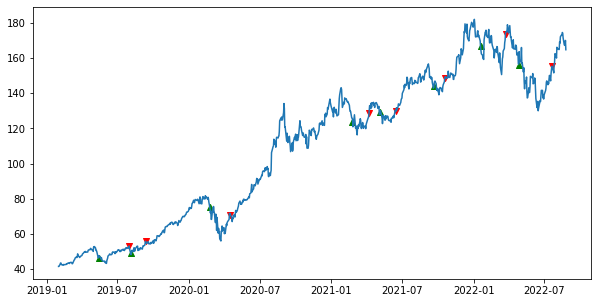

In [18]:
instance.plot_chart()